# CATS vs DOGS

# 0. Google CoLab일 경우
 * 아래의 Drive Mount 실행해주기

In [1]:
# My Google Drive Mount하기!
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Transfer Learning

* Let's make an intro to **VGG16**!

In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet', # None으로 줄 경우: Model의 구조만 가져오고 Weights는 안 가져온다.
    include_top=False,
    input_shape=(150, 150, 3)
)

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

## 1.1. 데이터 증식을 사용하지 않은 Features 추출하기

* Load Data

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/train'
val_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/validation'
test_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/test'

datagen = ImageDataGenerator(
    rescale=1/255.0
)

batch_size = 20

* conv_base를 통과시킨 후 (4, 4, 512)의 모양으로 나올 수 있게, 다음과 같이 User Defined Function을 만들자.

In [6]:
def ExtractFeatures(dir, sample_cnt):

    feature_arr = np.zeros(shape=(sample_cnt, 4, 4, 512))
    target_arr = np.zeros(shape=(sample_cnt))

    generator = datagen.flow_from_directory(
        dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    iCycle = 0

    for input_batch, target_batch in generator:

        feature_batch = conv_base.predict(input_batch)        

        feature_arr[iCycle * batch_size : (iCycle + 1) * batch_size] = feature_batch
        target_arr[iCycle * batch_size : (iCycle + 1) * batch_size] = target_batch

        iCycle = iCycle + 1

        if iCycle * batch_size >= sample_cnt:
            break
        
    return feature_arr, target_arr

* Now, train set/val set/test set에 대해 모두 conv_base를 통과시켜보자!

In [7]:
train_feature_arr, train_target_arr = ExtractFeatures(train_dir, 2000)
val_feature_arr, val_target_arr = ExtractFeatures(val_dir, 1000)
test_feature_arr, test_target_arr = ExtractFeatures(test_dir, 1000)

print(train_feature_arr.shape, train_target_arr.shape)
print(val_feature_arr.shape, val_target_arr.shape)
print(test_feature_arr.shape, test_target_arr.shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(2000, 4, 4, 512) (2000,)
(1000, 4, 4, 512) (1000,)
(1000, 4, 4, 512) (1000,)


* Now, 4 * 4 * 512로 표현된 것들을 **Flatten**해주자! (Dense Layers에 뿌려주기 위함임!)

In [8]:
train_feature_arr = np.reshape(
    train_feature_arr,
    (2000, 4 * 4 * 512)
)

val_feature_arr = np.reshape(
    val_feature_arr,
    (1000, 4 * 4 * 512)
)

test_feature_arr = np.reshape(
    test_feature_arr,
    (1000, 4 * 4 * 512)
)

print(train_feature_arr.shape)
print(val_feature_arr.shape)
print(test_feature_arr.shape)

(2000, 8192)
(1000, 8192)
(1000, 8192)


* Model Define + Compile + Fit

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

model1 = Sequential()

model1.add(Dense(256, activation='relu', input_shape=(4 * 4 * 512, )))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [10]:
model1.compile(
    optimizer=optimizers.RMSprop(lr=0.00002),
    loss='binary_crossentropy',
    metrics=['acc']
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history1 = model1.fit(
    train_feature_arr,
    train_target_arr,
    epochs=30,
    batch_size=20,
    validation_data=(val_feature_arr, val_target_arr)
)

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6067 - acc: 0.6740 - val_loss: 0.4611 - val_acc: 0.8280
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.4519 - acc: 0.8040 - val_loss: 0.3771 - val_acc: 0.8650
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3761 - acc: 0.8360 - val_loss: 0.3356 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3253 - acc: 0.8700 - val_loss: 0.3146 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2940 - acc: 0.8850 - val_loss: 0.2921 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2665 - acc: 0.8885 - val_loss: 0.2865 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2498 - acc: 0.9045 - val_loss: 0.2762 - val_acc: 0.8830
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.

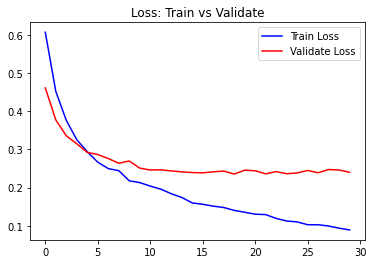

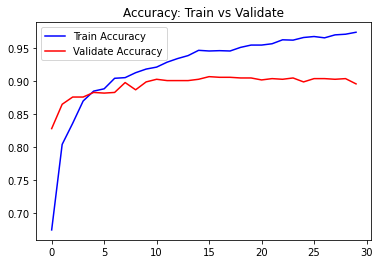

''

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

train_acc = history1.history['acc']
val_acc = history1.history['val_acc']

epoch_list = range(len(train_acc))

plt.plot(epoch_list, train_loss, 'b', label='Train Loss')
plt.plot(epoch_list, val_loss, 'r', label='Validate Loss')
plt.title('Loss: Train vs Validate')
plt.legend()

plt.figure()

plt.plot(epoch_list, train_acc, 'b', label='Train Accuracy')
plt.plot(epoch_list, val_acc, 'r', label='Validate Accuracy')
plt.title('Accuracy: Train vs Validate')
plt.legend()

plt.show()
;

* Wow! Week 09에서 내가 직접 만들었던 Model보다 확실히 성능이 훨씬 좋아졌군! XD

## 1.2. 데이터 증식을 사용하여 Features 추출하기

* First off, load partial VGG16 model!

In [13]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet', # None으로 줄 경우: Model의 구조만 가져오고 Weights는 안 가져온다.
    include_top=False,
    input_shape=(150, 150, 3)
)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

* Define End-to-End Model!

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

model2 = Sequential()

model2.add(conv_base)
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 4, 4, 256)         131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 4, 4, 1)           257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


* Now, Model을 Fit할 경우, 이미 weights가 다 결정된 conv_base의 weights를 또 계속 수정하게 된다.
* conv_base 부분은 수정 못하도록 **FREEZE**해줘야 한다!

In [15]:
conv_base.trainable = True

print(
    'Number of Trainable Weight Layers (before freezing conv_base):',
    len(model2.trainable_weights)
)

conv_base.trainable = False

print(
    'Number of Trainable Weight Layers (after freezing conv_base):',
    len(model2.trainable_weights)
)

Number of Trainable Weight Layers (before freezing conv_base): 30
Number of Trainable Weight Layers (after freezing conv_base): 4


In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 4, 4, 256)         131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 4, 4, 1)           257       
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


* Okay, Trainable params are now changed!

* Fit Model

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1/255.0
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
model2.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
history2 = model2.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_gen,
    validation_steps=50
)

Epoch 1/100


ValueError: ignored

In [ ]:
|model2.save('/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/cats_and_dogs_small_3.h5')

* Visualize Model Evaluations

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_acc = history2.history['acc']
val_acc = history2.history['val_acc']

train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epoch_list = range(len(train_acc))

plt.plot(epoch_list, train_acc, 'b', label='Train Acc')
plt.plot(epoch_list, val_acc, 'r', label='Validate Acc')
plt.title('Accuracy: Train vs Validate')
plt.legend()

plt.figure()

plt.plot(epoch_list, train_loss, 'b', label='Train Loss')
plt.plot(epoch_list, val_loss, 'r', label='Validate Loss')
plt.title('Loss: train vs Validate')
plt.legend()

plt.show()
;